# Addaction Analysis

Addaction have contacted us off the back of the blog on the impact on NCSO on local authorties and charities. We estimated in our blog that the impact of NCSO on Addaction is an additional £226,144.28 on top of a "usual" tariff cost of £47 257.92 giving a total of £273,402.2 in 2018. Addaction have estimated the impact on them is £403,474.59.

In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq

In [2]:
## SQL query to extract additonal costs of NHS price concessions. 
## This is a modfied version of the SQL query from OpenPrescribing.net NHS price concession calculator site i.e. done at a "organisational level" 
sql = '''SELECT
  ncso.date AS month,
  product.bnf_code AS bnf_code,
  product.name AS product_name,
  rx.quantity AS quantity,
  rx.pct AS pct,
  ccg.org_type,
  ccg.name,
  dt.price_pence
    * rx.quantity
    * CASE WHEN
        -- For some presentations "quantity" means "number of packs" rather
        -- than e.g. tablets. In these cases we don't want to divide by the
        -- quantity value of a pack. This is implemented via a flag in our
        -- databse but this data isn't in BiqQuery so we just have a hardcoded
        -- list of BNF codes here
        product.bnf_code in ('0206010F0AACJCJ')
      THEN
        1
      ELSE
        1 / vmpp.qtyval
      END
    -- This is the "discount factor" which applies the National Average 7.2%
    -- discount to estimate Actual Cost from Net Ingredient Cost and also
    -- converts figures from pence to pounds
    * 0.00928
    AS tariff_cost,
  COALESCE(ncso.price_concession_pence - dt.price_pence, 0)
    * rx.quantity
    * CASE WHEN
        product.bnf_code in ('0206010F0AACJCJ')
      THEN
        1
      ELSE
        1 / vmpp.qtyval
      END
    * 0.00928
    AS additional_cost,
  ncso.date != rx.month AS is_projection
FROM
  dmd.ncsoconcession AS ncso
JOIN
  dmd.tariffprice AS dt
ON
  ncso.vmpp = dt.vmpp AND ncso.date = dt.date
JOIN
  dmd.product AS product
ON
  dt.product=product.dmdid
JOIN
  dmd.vmpp AS vmpp
ON
  vmpp.vppid=ncso.vmpp
JOIN
  hscic.presentation AS presentation
ON
  presentation.bnf_code = product.bnf_code
JOIN
  hscic.prescribing AS rx
ON
  rx.bnf_code = product.bnf_code
JOIN
  hscic.ccgs AS ccg #this joins to our CCG organisational data
ON
  rx.pct = ccg.code
AND
-- Where we have prescribing data for the corresponding month we use
-- that, otherwise we use the latest month of prescribing data to
-- produce an estimate
(
  rx.month = ncso.date
  OR
  (
    -- This should be set to the latest date for which we have prescribing
    -- data
    rx.month = TIMESTAMP('2019-01-01')
    AND
    ncso.date > rx.month
  )
)'''
    
df_ncso = bq.cached_read(sql, csv_path='df_ncso.csv', use_cache=True)  # add `use_cache=False` to override
df_ncso.head()

,month,bnf_code,product_name,quantity,pct,org_type,name,tariff_cost,additional_cost,is_projection
0,2018-03-01,0106020C0AAAAAA,Bisacodyl 5mg gastro-resistant tablets,427,02F,CCG,NHS WEST CHESHIRE CCG,11.425381,12.349979,False
1,2018-03-01,0403040W0AAAAAA,Venlafaxine 37.5mg tablets,896,00C,CCG,NHS DARLINGTON CCG,27.023360,29.250560,False
2,2018-03-01,0202030X0AAAAAA,Eplerenone 25mg tablets,420,05G,CCG,NHS NORTH STAFFORDSHIRE CCG,62.779200,121.243200,False
3,2018-03-01,0704020N0AAABAB,Tolterodine 2mg tablets,616,08T,CCG,NHS SUTTON CCG,22.151360,13.576640,False
4,2018-03-01,0403040Y0AAAAAA,Duloxetine 30mg gastro-resistant capsules,700,05Q,CCG,NHS SOUTH EAST STAFFORDSHIRE AND SEISDON PENIN...,64.032000,35.032000,False


In [3]:
## import "independent providers" from NHS Digital ODS codes as this is where addaction is listed.
independent_providers = pd.read_csv(r'C:\Users\bmackenna\Documents\GitHub\jupyter-notebooks\nonCCG Concessions\ephp.csv')
independent_providers.head(5)

,pct,name,national_grouping,high_level_health_geography,address line 1,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,postcode,open_date,close_date
0,AA4,INTRAHEALTH LTD,Y54,Q74,"1ST FLOOR, WILLIAM BROWN CENTRE",MANOR WAY,NaN,PETERLEE,COUNTY DURHAM,SR8 5TW,20130401,NaN
1,AA5,COMPASS WELLBEING COMMUNITY INTEREST COMPANY,Y56,Q71,STEELS LANE HEALTH CENTRE,384-388 COMMERCIAL ROAD,NaN,LONDON,GREATER LONDON,E1 0LR,20130401,NaN
2,AA6,ASSISTED CONCEPTION UNIT LTD,Y56,Q71,LEYTONSTONE HOUSE,LEYTONSTONE,NaN,LONDON,GREATER LONDON,E11 1GA,20130401,NaN
3,AA7,LEYLAND PHYSIOTHERAPY,Y54,Q84,83 BOW LANE,NaN,NaN,LEYLAND,LANCASHIRE,PR25 4YB,20130401,NaN
4,AA8,SMART CJS,Y59,Q87,BUILDING B,KIRTLINGTON BUSINESS CENTRE,"SLADE FARM, KIRTLINGTON",KIDLINGTON,OXFORDSHIRE,OX5 3JA,20130401,NaN


In [4]:
## adding in independent provider names to our prescribing dataset result from SQL
indopro = df_ncso.merge(independent_providers[['pct','name']],  how="outer", on='pct')
indopro.head()

,month,bnf_code,product_name,quantity,pct,org_type,name_x,tariff_cost,additional_cost,is_projection,name_y
0,2018-03-01,0106020C0AAAAAA,Bisacodyl 5mg gastro-resistant tablets,427.0,02F,CCG,NHS WEST CHESHIRE CCG,11.425381,12.349979,False,NaN
1,2018-03-01,0106020C0AAAAAA,Bisacodyl 5mg gastro-resistant tablets,988.0,02F,CCG,NHS WEST CHESHIRE CCG,26.436245,28.575595,False,NaN
2,2017-10-01,0403040Y0AAABAB,Duloxetine 60mg gastro-resistant capsules,182.0,02F,CCG,NHS WEST CHESHIRE CCG,14.476800,78.958880,False,NaN
3,2017-10-01,0408010AEAAACAC,Pregabalin 75mg capsules,1008.0,02F,CCG,NHS WEST CHESHIRE CCG,30.234240,99.221760,False,NaN
4,2018-12-01,0704050R0AAADAD,Tadalafil 5mg tablets,168.0,02F,CCG,NHS WEST CHESHIRE CCG,33.630720,101.504640,False,NaN


In [5]:
## clearing blanks from the datset
df2 = indopro.dropna(subset=['name_y'])
df2

,month,bnf_code,product_name,quantity,pct,org_type,name_x,tariff_cost,additional_cost,is_projection,name_y
9266521,2018-12-01,1001010P0AAAIAI,Naproxen 500mg gastro-resistant tablets,140.0,NNF,Unknown,NaN,10.625600,18.420800,False,CITY HEALTH CARE PARTNERSHIP CIC
9266522,2018-08-01,0205051R0AAANAN,Ramipril 10mg tablets,28.0,NNF,Unknown,NaN,0.909440,2.060160,False,CITY HEALTH CARE PARTNERSHIP CIC
9266523,2018-12-01,0403030E0AAAAAA,Fluoxetine 20mg capsules,120.0,NNF,Unknown,NaN,2.264320,1.076480,False,CITY HEALTH CARE PARTNERSHIP CIC
9266524,2018-11-01,1106000AAAAAAAA,Brimonidine 0.2% eye drops,20.0,NNF,Unknown,NaN,5.048320,3.489280,False,CITY HEALTH CARE PARTNERSHIP CIC
9266525,2018-11-01,0501012G0AAABAB,Flucloxacillin 500mg capsules,300.0,NNF,Unknown,NaN,17.897143,3.281143,False,CITY HEALTH CARE PARTNERSHIP CIC
9266526,2018-12-01,0407020K0AAABAB,Diamorphine 10mg powder for solution for injec...,10.0,NNF,Unknown,NaN,19.933440,10.801920,False,CITY HEALTH CARE PARTNERSHIP CIC
9266527,2019-01-01,0202020L0AABBBB,Furosemide 20mg tablets,28.0,NNF,Unknown,NaN,0.501120,0.658880,False,CITY HEALTH CARE PARTNERSHIP CIC
9266528,2019-02-01,0205051R0AAAMAM,Ramipril 5mg tablets,28.0,NNF,Unknown,NaN,2.709760,0.399040,True,CITY HEALTH CARE PARTNERSHIP CIC
9266529,2019-03-01,1103010C0AAAAAA,Chloramphenicol 0.5% eye drops,10.0,NNF,Unknown,NaN,1.336320,0.974400,True,CITY HEALTH CARE PARTNERSHIP CIC
9266530,2019-01-01,1001040C0AAABAB,Allopurinol 300mg tablets,28.0,NNF,Unknown,NaN,2.143680,1.271360,False,CITY HEALTH CARE PARTNERSHIP CIC


In [6]:
## filtering the dataset to only include results where Addaction or similar is in the independent provider name
addaction2 = df2[df2["name_y"].str.contains("addaction", case=False)]
addaction2.head()

,month,bnf_code,product_name,quantity,pct,org_type,name_x,tariff_cost,additional_cost,is_projection,name_y
9900731,2018-06-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,162.0,NI3,Unknown,NaN,38.872594,195.222034,False,ADDACTION
9900732,2017-03-01,0403040X0AAAAAA,Mirtazapine 30mg tablets,91.0,NI3,Unknown,NaN,3.830320,1.025440,False,ADDACTION
9900733,2017-01-01,0403040X0AAAAAA,Mirtazapine 30mg tablets,121.0,NI3,Unknown,NaN,5.093063,1.363497,False,ADDACTION
9900734,2018-05-01,0410030A0AAADAD,Buprenorphine 2mg sublingual tablets sugar free,8968.0,NI3,Unknown,NaN,1105.677531,6443.841097,False,ADDACTION
9900735,2018-05-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,953.0,NI3,Unknown,NaN,228.676434,1811.723794,False,ADDACTION


In [7]:
## Counting how many variations on the name Addaction are retured
addaction2["name_y"].unique()

array(['ADDACTION'], dtype=object)

There is only one variation of the name Addaction in our dataset therefore we can be reasonably confident that our impact is correct as per the NHS BSA primary care prescribing/reimbursement dataset.

In [8]:
### see impact of NCSO in 2018
addaction2018 = addaction2.loc[(addaction2["month"]>="2018-01-01") & (addaction2["month"]<="2018-12-01")]
addaction2018

,month,bnf_code,product_name,quantity,pct,org_type,name_x,tariff_cost,additional_cost,is_projection,name_y
9900731,2018-06-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,162.0,NI3,Unknown,NaN,38.872594,195.222034,False,ADDACTION
9900734,2018-05-01,0410030A0AAADAD,Buprenorphine 2mg sublingual tablets sugar free,8968.0,NI3,Unknown,NaN,1105.677531,6443.841097,False,ADDACTION
9900735,2018-05-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,953.0,NI3,Unknown,NaN,228.676434,1811.723794,False,ADDACTION
9900736,2018-05-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,14.0,NI3,Unknown,NaN,3.359360,26.615040,False,ADDACTION
9900737,2018-04-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,105.0,NI3,Unknown,NaN,25.195200,8.073600,False,ADDACTION
9900738,2018-08-01,0410030A0AAADAD,Buprenorphine 2mg sublingual tablets sugar free,549.0,NI3,Unknown,NaN,67.686994,280.209600,False,ADDACTION
9900739,2018-08-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,181.0,NI3,Unknown,NaN,49.910491,163.888777,False,ADDACTION
9900740,2018-06-01,0410030A0AAAEAE,Buprenorphine 8mg sublingual tablets sugar free,146.0,NI3,Unknown,NaN,35.033326,175.940846,False,ADDACTION
9900742,2018-08-01,0410030A0AAADAD,Buprenorphine 2mg sublingual tablets sugar free,958.0,NI3,Unknown,NaN,118.113189,488.963200,False,ADDACTION
9900743,2018-08-01,0410030A0AAADAD,Buprenorphine 2mg sublingual tablets sugar free,701.0,NI3,Unknown,NaN,86.427291,357.790400,False,ADDACTION


In [16]:
### check impact for 2018
addaction2018.sum()

month              2018-06-012018-05-012018-05-012018-05-012018-0...
bnf_code           0410030A0AAAEAE0410030A0AAADAD0410030A0AAAEAE0...
product_name       Buprenorphine 8mg sublingual tablets sugar fre...
quantity                                                      278206
pct                NI3NI3NI3NI3NI3NI3NI3NI3NI3NI3NI3NI3NI3NI3NI3N...
org_type           UnknownUnknownUnknownUnknownUnknownUnknownUnkn...
name_x                                                             0
tariff_cost                                                  47257.9
additional_cost                                               226144
is_projection                                                      0
name_y             ADDACTIONADDACTIONADDACTIONADDACTIONADDACTIONA...
dtype: object

Now we will check the spend on Buprenorphine (BNF code = 0410030A0%) to see if Addaction are counting total impact instead of diferentiating between NCSO and "normal cost". The difference here is we are looking at all Buprenorphine products in all months of 2018. The previous analysis only look at products in months when they are NCSO.

In [17]:
sql = '''SELECT
  extract(year from month) AS year,
  bnf_code AS bnfcode,
  bnf_name AS bnfname,
  SUM(items) AS total_items,
  SUM(quantity) AS total_qty,
  SUM(actual_cost) AS actual_cost
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
WHERE
  bnf_code LIKE "0410030A0%"  
  and
  pct = "NI3" 
GROUP BY
  year,
  bnf_code,
  bnf_name'''
    
df_addaction = bq.cached_read(sql, csv_path='df_addaction.csv', use_cache=True)  # add `use_cache=False` to override
df_addaction.head()

,year,bnfcode,bnfname,total_items,total_qty,actual_cost
0,2012,0410030A0AAACAC,Buprenorphine_Tab Subling 400mcg S/F,210,6701,1725.76000
1,2019,0410030A0BBABAD,Subutex_Tab Subling 2mg,29,623,529.80435
2,2015,0410030A0AAAKAK,Buprenorphine_Tab Subling 4mg S/F,37,377,203.39000
3,2015,0410030A0AAACAC,Buprenorphine_Tab Subling 400mcg S/F,2882,102762,22053.27000
4,2011,0410030A0AAADAD,Buprenorphine_Tab Subling 2mg S/F,153,5997,6572.14000


In [18]:
### grouping the total cost by year
totalcost = df_addaction.groupby(['year'])['actual_cost'].sum()
totalcost

year
2010         3.72000
2011     53178.14000
2012    330436.05000
2013    315208.23000
2014    333620.98000
2015    247939.29000
2016    215990.79000
2017    171170.42258
2018    352194.52391
2019     51633.75501
Name: actual_cost, dtype: float64

(0, 400000)

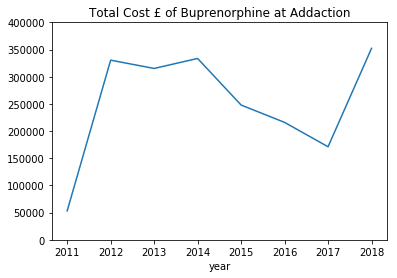

In [19]:
## graphing full years - i.e. get rid of 2010 and 2019 as incomplete
totalcostfullyearsonly = totalcost.drop([2010, 2019])
ax = totalcostfullyearsonly.plot(kind='line', title = "Total Cost £ of Buprenorphine at Addaction")
ax.set_ylim(0, 400000)


Addaction spent £352,194.52 on Buprenorphine  (BNF code = 0410030A0%) as per the prescribing file which is £51,280 short of their estimate of £403,474.59. We will now clarify/ask
-  What is the time frame? 18/19 has not finished so are they estimating or is the £403k a partial year spend?
-  What is the datset? for example is this invoiced?
-  Do they have other prescribing codes where the name is not similar to Addaction?
-  Do they pay through a "recharge" mechanism? e.g. a CCG pays and then invoices addaction